# Planning a surf trip using IOOS EDS Model Viewer

Created: 2022-11-25

Updated: 2022-11-25

Author: [Mathew Biddle](mailto:mathew.biddle@noaa.gov)

1. Look at significant wave height forecast for MD coast (38.2101 °N 75.0867 °W). Look for significant wave heights >1m or some significant increase to narrow down the investigation. This will get you to a 12-24 hour window typically.
   * Resources in EDS include:
     * Wave Watch III (WW3) WW3 Wave Hgt @ NOAA WW3 Wave Height https://edsdata.oceansmap.com/thredds/catalog/EDS/NOGAPS/catalog.html
     * GFS-Wave WW3 Atlantic Height @ NOAA GFS-Wave Atlantic Wave Height https://eds.ioos.us/thredds/catalog/ioos/gfswave/global/catalog.html
     * The Nearshore Wave Prediction System (NWPS) Chesapeake NWPS AKQ Wave Hgt @ NOAA NWPS Chesapeake Wave Height - https://eds.ioos.us/thredds/catalog/ioos/nwps/akq/catalog.html
1. Once you find a blip in wave heights, take a look at wave periods in that time period to see if it's just a storm or a decent offshore swell. Typically periods >5 seconds is a good start. That should get you down to a 12 hour window where it might be decent to surf.
1. Next look at the forecasted wave direction and wind direction/speed. Lots of nuances in these two pieces as wind direction could be bad (onshore) but if speeds are low it could be alright. If wind direction good (offshore) but winds are strong, could be tricky. wave direction informs which spots would catch the swell. Not many features on MD coast (barrier island), so direction not as important. This should get you to a 6 hour'ish window.
1. Finally, look at tides and water temp (wetsuit or trunks?), sunrise, sunset times.
1. Run this process every hour leading up to the event - forecast will get more accurate the closer to the event. I will start looking at real-time buoy obs ~12 hours before the event.

In [ ]:
# from siphon.catalog import TDSCatalog
# import matplotlib.pyplot as plt
# import numpy as np
# import ipywidgets as widgets

# Set up coordinates for forecast

In [1]:
lat = 38.2101
lon = -75.0867 
lon = 360+lon # convert to degrees_east 0-360
print('lat: {}\nlon: {}'.format(lat,lon))

lat: 38.2101
lon: 284.9133


# GFS WW3

![image.png](gfs_surf_screenshot.png)

https://eds.ioos.us/thredds/catalog/ioos/gfswave/global/catalog.html

Just use xarray to open dataset directly.

In [14]:
#import cf_xarray
import xarray as xr


In [15]:
url = 'https://eds.ioos.us/thredds/dodsC/ioos/gfswave/global/Best'

ds = xr.open_dataset(url)

ds
#wvght = ds['Significant_height_of_combined_wind_waves_and_swell_surface']

<xarray.Dataset>
Dimensions:                                                      (lat: 721,
                                                                  lon: 1440,
                                                                  time: 983,
                                                                  ordered_sequence_of_data: 3)
Coordinates:
  * lat                                                          (lat) float32 ...
  * lon                                                          (lon) float32 ...
  * time                                                         (time) datetime64[ns] ...
    reftime                                                      (time) datetime64[ns] ...
  * ordered_sequence_of_data                                     (ordered_sequence_of_data) float32 ...
Data variables: (12/14)
    LatLon_Projection                                            int32 ...
    Direction_of_swell_waves_ordered_sequence_of_data            (time, ordered_sequence_of_data, lat, lon) float32 ...
    Mean_period_of_swell_waves_ordered_sequence_of_data          (time, ordered_sequence_of_data, lat, lon) float32 ...
    Significant_height_of_swell_waves_ordered_sequence_of_data   (time, ordered_sequence_of_data, lat, lon) float32 ...
    Wind_direction_from_which_blowing_surface                    (time, lat, lon) float32 ...
    Wind_speed_surface                                           (time, lat, lon) float32 ...
    ...                                                           ...
    v-component_of_wind_surface                                  (time, lat, lon) float32 ...
    Direction_of_wind_waves_surface                              (time, lat, lon) float32 ...
    Significant_height_of_wind_waves_surface                     (time, lat, lon) float32 ...
    Mean_period_of_wind_waves_surface                            (time, lat, lon) float32 ...
    Primary_wave_direction_surface                               (time, lat, lon) float32 ...
    Primary_wave_mean_period_surface                             (time, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

In [16]:
wvhgt = ds.Significant_height_of_combined_wind_waves_and_swell_surface.sel(lat=lat, lon=lon, method="nearest")

wvhgt

<xarray.DataArray 'Significant_height_of_combined_wind_waves_and_swell_surface' (
                                                                                 time: 983)>
[983 values with dtype=float32]
Coordinates:
    lat      float32 38.25
    lon      float32 285.0
  * time     (time) datetime64[ns] 2022-10-27T18:00:00 ... 2022-12-15
    reftime  (time) datetime64[ns] ...
Attributes: (12/13)
    long_name:                       Significant height of combined wind wave...
    units:                           m
    abbreviation:                    HTSGW
    grid_mapping:                    LatLon_Projection
    Grib_Variable_Id:                VAR_7-0--1-3_L1
    Grib2_Parameter:                 [10  0  3]
    ...                              ...
    Grib2_Parameter_Category:        Waves
    Grib2_Parameter_Name:            Significant height of combined wind wave...
    Grib2_Level_Type:                1
    Grib2_Level_Desc:                Ground or water surface
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Statistical_Process_Type:  UnknownStatType--1

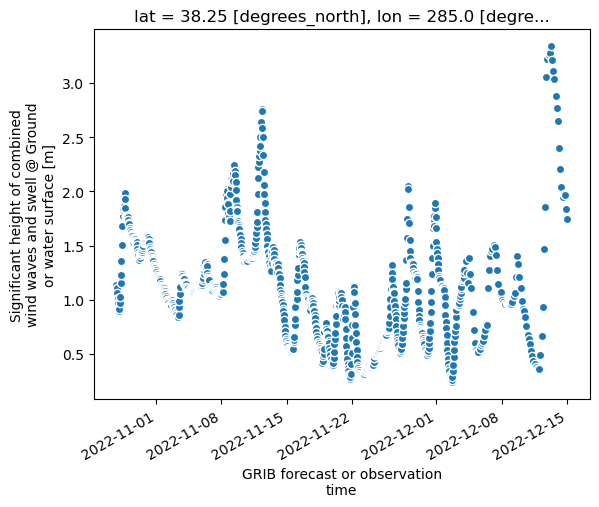

In [17]:
wvhgt.plot.scatter(x='time')

# NOAA WW3

In [18]:
url = 'http://edsdata.oceansmap.com/thredds/dodsC/EDS/NOGAPS/WW3_WAVE_HGT20221128.nc'

ds = xr.open_dataset(url)

ds.significant_height_of_combined_wind_waves_and_swells.sel(lat=lat, lon=lon, method="nearest")

wvhgt

<xarray.DataArray 'Significant_height_of_combined_wind_waves_and_swell_surface' (
                                                                                 time: 983)>
[983 values with dtype=float32]
Coordinates:
    lat      float32 38.25
    lon      float32 285.0
  * time     (time) datetime64[ns] 2022-10-27T18:00:00 ... 2022-12-15
    reftime  (time) datetime64[ns] ...
Attributes: (12/13)
    long_name:                       Significant height of combined wind wave...
    units:                           m
    abbreviation:                    HTSGW
    grid_mapping:                    LatLon_Projection
    Grib_Variable_Id:                VAR_7-0--1-3_L1
    Grib2_Parameter:                 [10  0  3]
    ...                              ...
    Grib2_Parameter_Category:        Waves
    Grib2_Parameter_Name:            Significant height of combined wind wave...
    Grib2_Level_Type:                1
    Grib2_Level_Desc:                Ground or water surface
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Statistical_Process_Type:  UnknownStatType--1

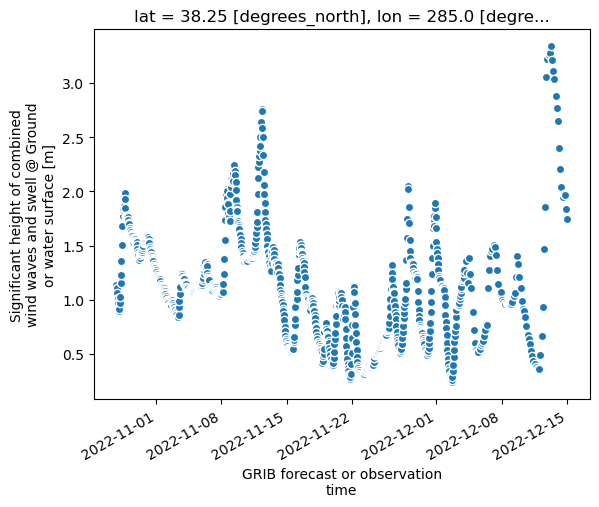

In [19]:
wvhgt.plot.scatter(x='time')

# Nearshore Wave Prediction System (NWPS) Chesapeake NWPS AKQ Wave Hgt

In [12]:
url = 'https://eds.ioos.us/thredds/dodsC/ioos/nwps/akq/NWPS_AKQ-2022-11-28/LatLon_229X153-37p66N-75p76W'

ds = xr.open_dataset(url)

wvhgt = ds.Significant_height_of_combined_wind_waves_and_swell_surface.sel(lat=lat, lon=lon, method="nearest")

wvhgt

<xarray.DataArray 'Significant_height_of_combined_wind_waves_and_swell_surface' (
                                                                                 reftime: 3,
                                                                                 timeOffset: 145)>
[435 values with dtype=float32]
Coordinates:
    lat         float32 38.22
    lon         float32 284.9
  * reftime     (reftime) datetime64[ns] 2022-11-28 ... 2022-11-28T12:00:00
  * timeOffset  (timeOffset) float64 0.0 1.0 2.0 3.0 ... 141.0 142.0 143.0 144.0
    time        (reftime, timeOffset) datetime64[ns] ...
Attributes: (12/13)
    long_name:                       Significant height of combined wind wave...
    units:                           m
    abbreviation:                    HTSGW
    grid_mapping:                    LatLon_Projection
    Grib_Variable_Id:                VAR_10-0-3_L1
    Grib2_Parameter:                 [10  0  3]
    ...                              ...
    Grib2_Parameter_Category:        Waves
    Grib2_Parameter_Name:            Significant height of combined wind wave...
    Grib2_Level_Type:                1
    Grib2_Level_Desc:                Ground or water surface
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Statistical_Process_Type:  UnknownStatType--1

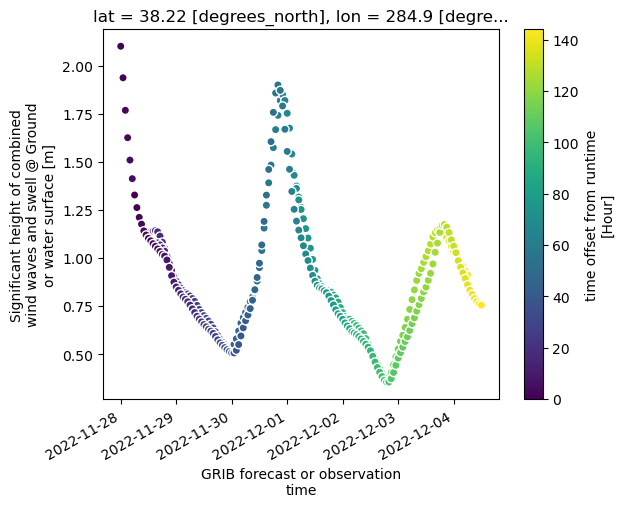

In [13]:
wvhgt.plot.scatter(x='time')

In [ ]:
catUrl = "https://eds.ioos.us/thredds/catalog/ioos/gfswave/global/catalog.xml"
datasetName = "GFS Wave Global 25km-2022-11-25"

Trying to use siphon to get to `https://eds.ioos.us/thredds/dodsC/ioos/gfswave/global/GFS_Wave_Global_25km-2022-11-25.html`

In [ ]:
from siphon.catalog import TDSCatalog

catalog = TDSCatalog("https://eds.ioos.us/thredds/catalog/ioos/gfswave/global/catalog.xml")


info = """
Catalog information
-------------------

Base THREDDS URL: {}
Catalog name: {}
Catalog URL: {}
Metadata: {}
""".format(
    catalog.base_tds_url, catalog.catalog_name, catalog.catalog_url, catalog.metadata
)

print(info)

In [ ]:
for service in catalog.services:
    print(service.name)

In [ ]:
print("\n".join(catalog.datasets.keys()))

In [ ]:
print("\n".join(catalog.catalog_refs.keys()))

In [ ]:
import datetime
today = datetime.datetime.now().isoformat().split("T")[0]

dataset = "GFS Wave Global 25km-{}".format(today)

dataset

In [ ]:
ref = catalog.catalog_refs[dataset]

In [ ]:
cat = ref.follow()

print(type(cat))

cat.catalog_url

In [ ]:
print("\n".join(cat.datasets.keys()))

In [ ]:
ds = cat.datasets[dataset]

ds.name, ds.url_path

In [ ]:
for name, ds in catalog.datasets.items():
    if ds.access_urls:
        print(name)

In [ ]:
catalog.services

for service in catalog.services:

    print('{}: {}'.format(service.name,service.service_type))

In [ ]:
service.remote_access()

---
### Access a dataset
With the TDS catalog url, we can use Siphon to get the dataset named `datasetName`.

In [ ]:
catalog = TDSCatalog(catUrl)

In [ ]:
catalog.datasets

In [ ]:
ds = catalog.datasets[datasetName]
ds.name

Datasets each have a set of access protocols:

In [ ]:
ds.access_urls

In [ ]:
list(ds.access_urls)

Siphon's `remote-access` returns a `Dataset` object, which opens the remote dataset and provides access to its metadata:

In [ ]:
dataset = ds.remote_access()

In [ ]:
list(dataset.ncattrs())

### Display a variable:
1) Create a widget to select from a list of all variables in this dataset.


In [ ]:
var_name = widgets.RadioButtons(
    options=list(dataset.variables),
    description='Variable:')


2) Run the cell below to display the widget.  
3) Select the variable you wish to view.

In [ ]:
display(var_name)

4) Display information about the chosen variable

In [ ]:
var = dataset.variables[var_name.value];
print("Name: " + var.name);
print("Dimensions: " + str(list(var.dimensions)));
print("Shape: " + str(var.shape));
import operator
from functools import reduce
nelems = reduce(operator.mul, var.shape, 1);
print("# elements: " + str(nelems));
print("Datatype: " + str(var.dtype));

5) Attempt to plot the variable.

In [ ]:
# EDIT these values to print or plot fewer/more elements
max_print_elems = 1000; # don't print more than this number of elements
max_elems = 10000; # don't request more than this number of elements (<100M to avoid HTTP errors)

# only atttempt to plot numeric types
if (not(var.dtype == np.uint8 or np.can_cast(var.dtype, float, "same_kind"))):
    print("Not a numeric type - cannot plot variable: ", var.name);
    if (nelems > max_print_elems):
        print("Too many elements - printing first " + str(max_print_elems) + " elements");
        var = var.flatten()[0:max_print_elems];
        print(var);
        
else:
    # assure plotable number of dimensions
    ndims = len([s for s in var.shape if s > 1]);
    max_dims = 2;
    shape = np.array(var.shape);
    if (ndims > max_dims):
        print("Too many dimensions - reducing last " + str(ndims-max_dims) + " dimensions.")
        shape[np.argwhere(shape>1).flatten().tolist()[max_dims:]] = 1;
        print("New shape: " + str(shape))
        ndims = max_dims;

    # assure plotable number of elements   
    nelems = reduce(operator.mul, shape, 1);
    scale = (nelems/max_elems)**(1/ndims) if ndims else 0;
    if (scale > 1):
        print("Too many elements - subsetting variable")
        shape[np.argwhere(shape>1).flatten().tolist()] = shape[np.argwhere(shape>1).flatten().tolist()]//scale;
        print("New shape: " + str(shape));
              
    # EDIT indices variable to change the number/indices of plotted elements
    to_slice = lambda x : slice(None, x, None)
    indices = [to_slice(s) for s in shape]
    
    # make copy of (possible) subset of variable
    disp_var = var[indices];

    # plot the variable
    %matplotlib inline
    # for one-dimensional data, print value
    if (ndims == 0):
        print(var.name, ": ", disp_var)
    # for two-dimensional data, make a line plot
    elif (ndims == 1):
        plt.plot(np.squeeze(np.array([range(len(np.squeeze(disp_var[:])))])), np.squeeze(disp_var[:]), 'bo', markersize=5)
        plt.title(var.name)
        plt.show()
    # for three-dimensional data, make an image
    elif (ndims == 2):
        plt.imshow(np.squeeze(disp_var[:]))
        plt.title(var.name)
        plt.show()

**Note** that data are only transferred over the network when the variable is sliced, and only data corresponding to the slice are downloaded. In this case, we are ask for a subset of the data with `disp_var = var[indices]`. You may change the values to `indices` to request a different subset of data.

---

6) To plot a different variable, select it in the widget and rerun the subsequent cells.

### More with Siphon
To see what else you can do, view the [Siphon API](https://unidata.github.io/siphon/latest/api/index.html).

In [ ]:
### Your code here ###